In [1]:
import sympy
from sympy.combinatorics import Permutation, PermutationGroup
from sympy.combinatorics.named_groups import SymmetricGroup

import torch
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.autograd import grad
from torch.optim import Adam
from torch.nn import Linear,Tanh
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm

import time
import copy
from os import path
import sys
import json

import matplotlib.pyplot as plot
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=np.inf)
plot.rcParams["figure.figsize"] = (8,6)
plot.rcParams["axes.formatter.limits"] = (-99, 99)

cuda = torch.device('cuda')

## Dataset Processing

In [2]:
def json_formatter(data_dict):
    keys = list(data_dict.keys())
    data_list = []
    for d in data_dict['data']:
        word = d[0]
        order = d[1]
        data = (d[0], d[1])
        data_list.append(data)
    return data_list

class Sn_Dataset(Dataset):
    #Pytorch dataset class for loading in data from JSON file. Has options for variable word length but are not used as of yet. 
    def __init__(self, data_file, max_length, transform = None,
                 target_transform = None):
        with open(data_file, "r") as f:
            data_dict = json.load(f)
        self.data_list = json_formatter(data_dict)
        self.max_length = max_length
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        word = torch.Tensor(data[0])
        order = data[1]
        word_length = self.max_length
        if self.transform:
            word = self.transform(word, word_length)
        if self.target_transform:
            order = self.target_transform(order)
        return word, order
    
def onehot(word, word_length, num_generators = 10):
    #Convert a generator string to onehot encoding
    val = torch.zeros((word_length, num_generators))
    for i in range(len(word)):
        val[i,int(word[i])] = 1
    return val
    
class onehot_transform:
    #Transform class for data loading in pytorch. Applies the onehot transformation to the input data.
    def __init__(self, num_generators = 10):
        self.num_generators = num_generators
    def __call__(self, word, word_length):
            matrix = onehot(word, word_length, num_generators = self.num_generators)
            return matrix

class target_prob_transform:
    def __init__(self,classes):
        self.classes = classes
    def __call__(self,order):
        vec = torch.zeros((1,self.classes))
        
        if order == 1:
            order = 0
        elif order == 2:
            order = 1
        elif order == 3:
            order = 2
        elif order == 4:
            order = 3
        elif order == 5:
            order = 4
        elif order == 6:
            order = 5
        elif order == 7:
            order = 6
        elif order == 8:
            order = 7
        elif order == 9:
            order = 8
        elif order == 10:
            order = 9
        elif order == 12:
            order = 10
        elif order == 14:
            order = 11
        elif order == 15:
            order = 12
        elif order == 20:
            order = 13
        elif order == 21:
            order = 14
        else:
            order = 15
        vec[0,order] = 1
        return vec
        
        
class S10_class_transform:
    def __init__(self):
        pass
    def __call__(self,order):
        #Yikes
        if order == 1:
            return 0
        elif order == 2:
            return 1
        elif order == 3:
            return 2
        elif order == 4:
            return 3
        elif order == 5:
            return 4
        elif order == 6:
            return 5
        elif order == 7:
            return 6
        elif order == 8:
            return 7
        elif order == 9:
            return 8
        elif order == 10:
            return 9
        elif order == 12:
            return 10
        elif order == 14:
            return 11
        elif order == 15:
            return 12
        elif order == 20:
            return 13
        elif order == 21:
            return 14
        else:
            return 15

## Setup Network

In [3]:
class SnResClassifier(torch.nn.Module):
    def __init__(self,gens,classes,max_len,layers,neurons,res_neurons,res_layers,rep_size):
        super(SnResClassifier,self).__init__()
        self.cuda(device=cuda)
        
        self.actf = torch.nn.SiLU()#torch.nn.SiLU()
        self.resactf = torch.nn.SiLU()#Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        
        self.resinput = Linear(gens,res_neurons)
        self.reslayers = torch.nn.ModuleList([Linear(res_neurons, res_neurons) for i in range(res_layers)])
        self.resout = Linear(res_neurons,rep_size**2)
        
        self.input = Linear(rep_size**2,neurons)
        self.layers = torch.nn.ModuleList([Linear(neurons, neurons) for i in range(layers)])
        self.out = Linear(neurons,classes)
        
        self.softmax = torch.nn.Softmax()
        
        self.gens = gens
        self.rep_size = rep_size
        self.max_len = max_len
        
    def res_block(self, onehot_mat,printout = False):
        #Res/Recurrent block that computes matrix
        X = self.resinput(onehot_mat)
        for h in self.reslayers:
            X = self.resactf(h(X))
        out = self.resout(X) 
        out = out.reshape((-1,self.rep_size, self.rep_size))
        out = torch.matrix_exp(out) #- torch.eye(self.rep_size,device='cuda',requires_grad=True)
        if printout:
            print(out)
        return out
    
    def forward(self,onehot_mat,printout = False,printseq = False):
        #print(onehot_mat.shape)
        mat_rep = self.res_block(onehot_mat[:,0,:],printout)
        if printseq:
            print(mat_rep)
        for i in range(self.max_len-1):
            temp = self.res_block(onehot_mat[:,i+1,:],printout)
            mat_rep = torch.matmul(mat_rep, temp)
            if printseq:
                print(mat_rep)
            
        X = self.input(mat_rep.reshape(-1,self.rep_size**2))
        for h in self.layers:
            X = self.actf(h(X))
        out = self.sigmoid(self.out(X))
        return out 

In [4]:
max_len = 16; gens = 10; unique_orders = 16

In [5]:
nn1 = SnResClassifier(gens=gens,classes=unique_orders,max_len=max_len,layers=2,neurons=256,res_layers=2,res_neurons=128,rep_size=gens)
nn1.to(cuda)
optimizer = Adam(nn1.parameters(), lr=4e-4)

In [40]:
optimizer = Adam(nn1.parameters(), lr=8e-4)

In [7]:
batch_size = 1000#25000
sn_dataset = Sn_Dataset('S10_250k_smallword_data.json',max_length=max_len,transform=onehot_transform(num_generators = gens),target_transform=target_prob_transform(classes=unique_orders))#Sn_Dataset('S10_data.json',max_length=64,transform=None)
sn_train, sn_test = random_split(sn_dataset, [0.8, 0.2])
train_dataloader = DataLoader(sn_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(sn_test, batch_size=50000, shuffle=True)

In [7]:
sn_train = torch.load('datasets/working_train.pt')
sn_test = torch.load('datasets/working_test.pt')

In [8]:
train_dataloader = DataLoader(sn_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(sn_test, batch_size=50000, shuffle=True)

In [8]:
loss_history = []
test_history = []

loss_index = []
test_index = []

In [10]:
savepoint = torch.load('saved_models/S10_works')
nn1.load_state_dict(savepoint['model_state_dict'])
optimizer.load_state_dict(savepoint['optimizer_state_dict'])

In [ ]:
num_epochs = 500
loss_fn = torch.nn.BCELoss()
for i in tqdm(range(num_epochs)):
    for train_step, batch in enumerate(train_dataloader):
        onehot_set = batch[0].to(cuda)#.flatten(start_dim=1,end_dim=-1)
        order_set = batch[1].to(cuda).float()[:,0,:]
        #onehot_word = onehot_set[i].flatten()

        optimizer.zero_grad()

        pred = nn1(onehot_set)

        loss = loss_fn(pred, order_set)
        loss_history.append(loss.cpu().item())
        loss_index.append(i)
        loss.backward()
        optimizer.step()
    if i%1==0:
        nn1.eval()
        for train_step, batch in enumerate(test_dataloader):
            onehot_set = batch[0].to(cuda)#.flatten(start_dim=1,end_dim=-1)
            order_set = batch[1].to(cuda).float()[:,0,:]

            pred = nn1(onehot_set)
            loss = loss_fn(pred, order_set)
            test_history.append(loss.cpu().item())
            test_index.append(len(loss_index))
        nn1.train()

  2%|▏         | 12/500 [08:02<5:25:32, 40.03s/it]

Text(0.5, 1.0, 'Training Loss')

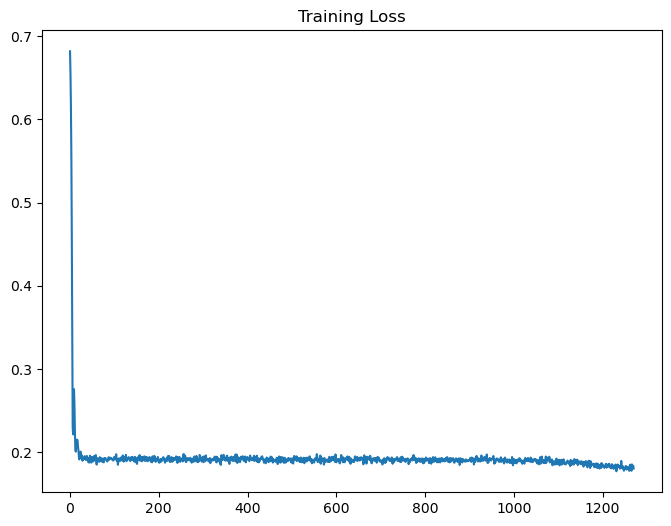

In [10]:
plot.plot(loss_history)
plot.title('Training Loss')

Text(0.5, 1.0, 'Eval Loss')

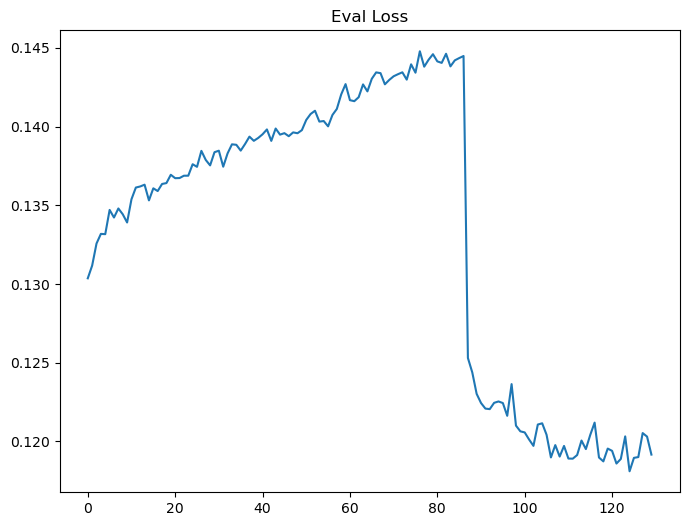

In [53]:
plot.plot(test_history)
plot.title('Eval Loss')

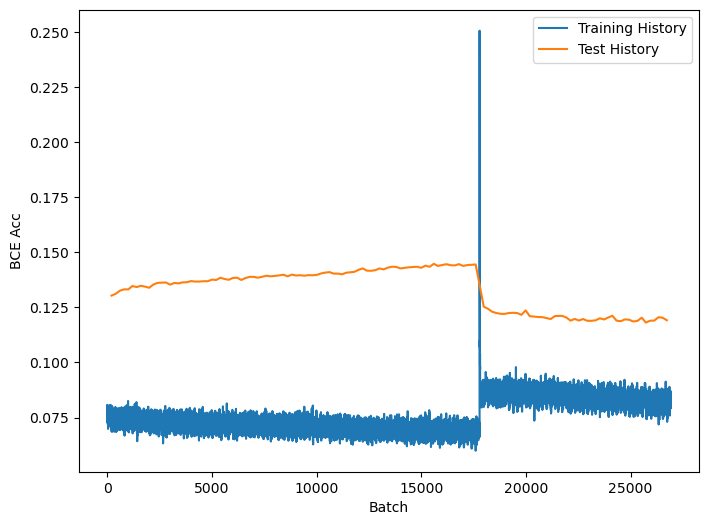

In [54]:
plot.plot(loss_history,label='Training History')
plot.plot(test_index,test_history,label='Test History')
plot.xlabel('Batch')
plot.ylabel('BCE Acc')
plot.legend()

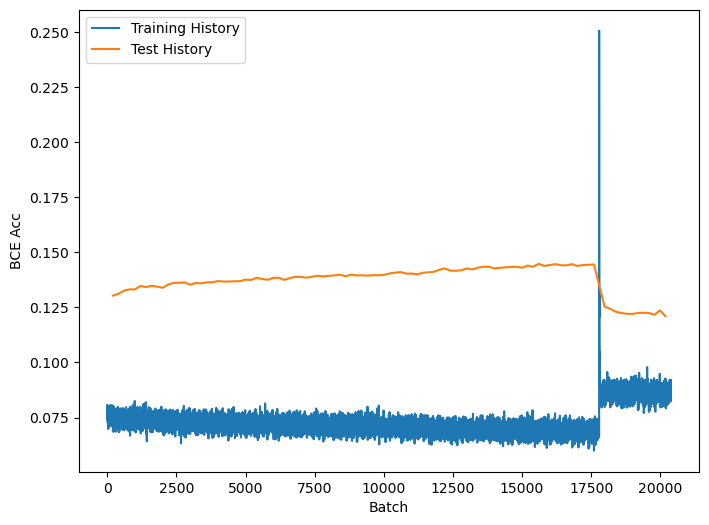

In [45]:
plot.plot(loss_history,label='Training History')
plot.plot(test_index,test_history,label='Test History')
plot.xlabel('Batch')
plot.ylabel('BCE Acc')
plot.legend()

Text(0.5, 1.0, 'Eval Loss')

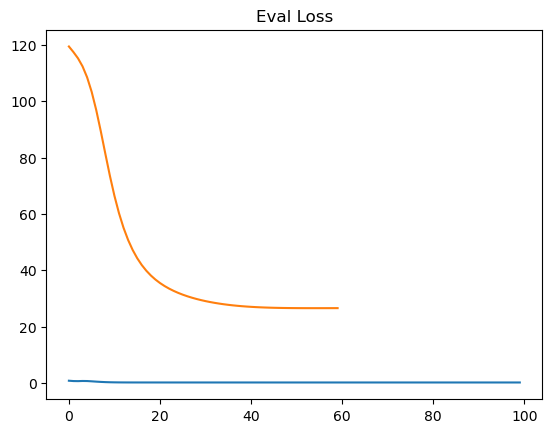

In [16]:
plot.plot(test_history)
plot.plot(b, label='8e-4 LR')
plot.title('Eval Loss')

In [17]:
x,y = sn_dataset[170]

In [18]:
pred = nn1(x.cuda().reshape(1,64,10)); print(pred.item())

RuntimeError: a Tensor with 16 elements cannot be converted to Scalar

In [ ]:
y

In [ ]:
print(str(abs(pred.item()-y))+' | '+str((pred.item()-y)**2))

(array([[ 949.,  478., 1577., 4074.,  478.,  111., 1528.,  191.,  494.,
          119.],
        [ 958.,  529., 1816., 3357.,  445.,  101., 1841.,  205.,  583.,
          164.]]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 2 BarContainer objects>)

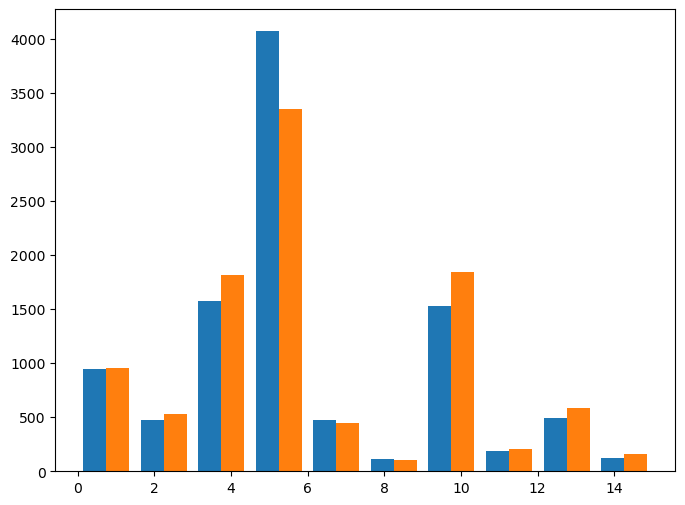

In [46]:
temp = iter(test_dataloader)
x,y = next(temp)
plot.hist((torch.max(nn1(x[1:10000].cuda()),dim=1)[1].detach().cpu().numpy().squeeze(),torch.max(y[1:10000],dim=2)[1].reshape(-1,1).numpy().squeeze()))

In [ ]:
plot.hist(y)

In [ ]:
pred = nn1(x.cuda()).detach().cpu()

In [ ]:
pred.shape

In [ ]:
pred[0:10]

In [ ]:
plot.hist((pred[0:1000].squeeze(),y[0:1000]))

In [ ]:
plot.show()

In [155]:
torch.save({
'model_state_dict': nn1.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
}, 'saved_models/S10_works')

In [ ]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

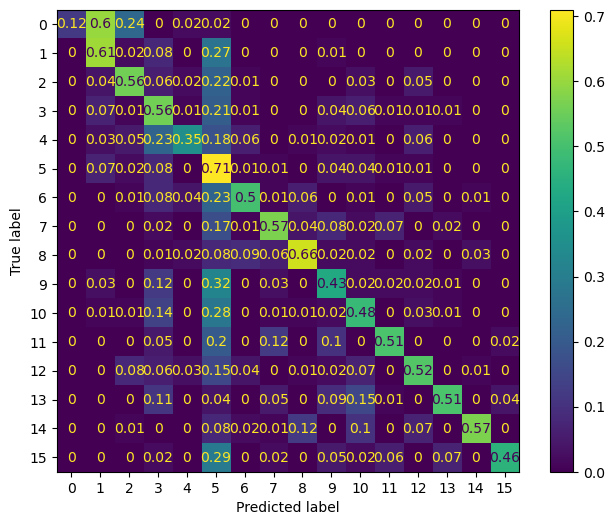

In [55]:
temp = iter(test_dataloader)
x,y = next(temp)
cm =confusion_matrix((torch.max(y[1:50000],dim=2)[1].reshape(-1,1).numpy().squeeze()) , (torch.max(nn1(x[1:50000].cuda()),dim=1)[1].detach().cpu().numpy().squeeze()), normalize='true')
ConfusionMatrixDisplay(np.around(cm,2)).plot()

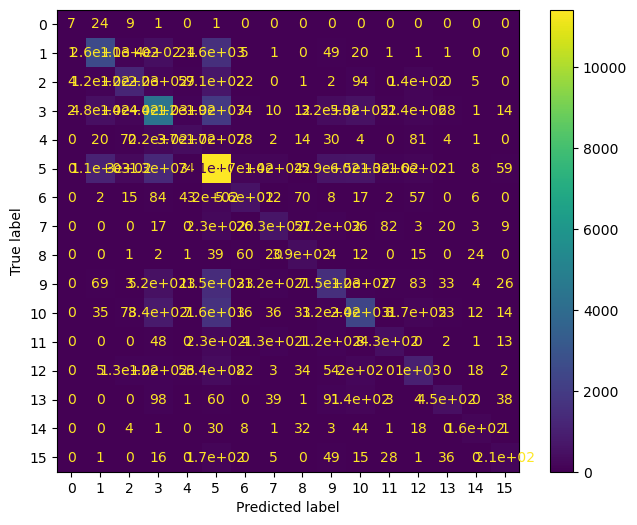

In [136]:
temp = iter(test_dataloader)
x,y = next(temp)
cm =confusion_matrix((torch.max(y[1:50000],dim=2)[1].reshape(-1,1).numpy().squeeze()) , (torch.max(nn1(x[1:50000].cuda()),dim=1)[1].detach().cpu().numpy().squeeze()))
ConfusionMatrixDisplay(np.floor(cm)).plot()

In [139]:
torch.save(sn_train, 'datasets/working_train.pt')
torch.save(sn_test, 'datasets/working_test.pt')